<a href="https://colab.research.google.com/github/mateusz-wozny/IMO/blob/main/GreedyCycle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 1

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
def createDistanceMatrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]
  return np.array(outputMatrix)

In [16]:
def chooseNearestVertex(matrix, used_vertexes, node):
  return np.argmin([matrix[node][i] if i not in used_vertexes and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [17]:
def calculateCycleLength(matrix, vertexes):
  length = 0
  for graph in vertexes:
    length += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])

#   print(length)
  return length

In [18]:
def find_nearest(matrix, lista, unvisited):
    df = matrix[:, lista][unvisited, :]
    indx, indy = np.unravel_index(df.argmin(), df.shape)
    return unvisited[indx], lista[indy]

In [19]:
def random_heuristic(matrix, start):
    N = matrix.shape[0]
    a = random.sample(range(N), N)
    list1 = a[:N//2]
    list1.append(list1[0])
    list2 = a[N//2:]
    list2.append(list2[0])
    return [list1, list2]

In [20]:
def nearest_neighbor(matrix, start):
    end = np.argmax(matrix[start, :])
    unvisited = list(range(matrix.shape[0]))
    unvisited.remove(start)
    unvisited.remove(end)
    list1 = [start]
    list2 = [end]
    while len(unvisited) != 0:
        nearest, vertex = find_nearest(matrix, list1, unvisited)
        list1.insert(list1.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
        if len(unvisited) == 0:
          break
        nearest, vertex = find_nearest(matrix, list2, unvisited)
        list2.insert(list2.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
    list1.append(start)
    list2.append(end)

    return [list1, list2]

In [21]:
def greedyCycle(matrix, start_node):
    #Starting node 2
    start_node_2 = np.argmax(matrix[start_node])

    #Choosing nearest vertex for cycles
    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    #Creating cycles
    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    #Calculating cycles
    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]

        z = np.inf
        x = np.inf
        c = np.inf

        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                if value < z:
                    z = value
                    x = j + 1
                    c = nearest

        if len(cycles[0]) <= len(cycles[1]):
            cycles[0].insert(x, c)
        else:
            cycles[1].insert(x, c)

    return cycles

In [22]:
def two_regret(matrix, start_node):
    start_node_2 = np.argmax(matrix[start_node])

    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]
        z = -np.inf
        x = np.inf
        c = np.inf
        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            values = {}
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                values.update({j:value})
            values = dict(sorted(values.items(), key= lambda x:x[1]))
            keys = list(values.keys())
            value = values[keys[1]] - 1.5*values[keys[0]]
            if value > z:
                z = value
                x = keys[0] + 1
                c = nearest

            
        if len(cycles[0]) <= len(cycles[1]):
                cycles[0].insert(x, c)
        else:
                cycles[1].insert(x, c)

    return cycles

In [23]:
def draw_plot(vertices, visited, length, filename):
  for graph in visited:
    x = vertices[graph, 0]
    y = vertices[graph,1]
    plt.plot(x, y)
  plt.scatter(vertices[:, 0], vertices[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [24]:
def draw_best(ver_data, lengths, heuris, filename):
  best_start_node = np.argmin(lengths)
  distance_matrix = createDistanceMatrix(ver_data)
  vertexes = heuris(distance_matrix, best_start_node)
  min_length = lengths[best_start_node]
  draw_plot(ver_data, vertexes, min_length, filename)

In [31]:
def test(n, heuris, ver_data):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    length = calculateCycleLength(distance_matrix, vertexes)
    lengths.append(length)
  return lengths

In [ ]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

In [32]:
#Four heuris to choose: random_heuristic, nearest_neighbor, greedyCycle, two_regret 
lengths = test(100, heuris = two_regret,ver_data =  ver_data)
print(f'{round(sum(lengths)/len(lengths))} ({min(lengths)}-{max(lengths)})')

26550 0
26336 3
24586 4
24380 5
24329 10
23619 20
23546 22
26900 (23546-30422)


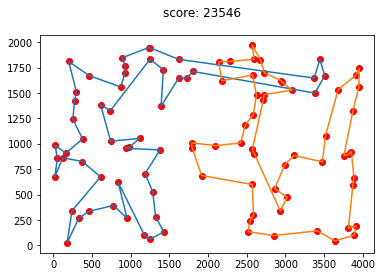

In [39]:
draw_best(ver_data, lengths, greedyCycle, 'cycleB')

# LAB 2

In [795]:
def swap_vertex(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  n = len(copy)
  copy.remove(vertex)
  return list(zip(["vertex"]*(n-1), copy, [vertex]*(n-1), [i]*(n-1)))

In [796]:
def swap_vertex_cycle(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  n = len(copy)
  return list(zip(["cycle"]*n, copy, [vertex]*(n), [i]*(n)))

In [797]:
def swap_edges(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  n = len(copy)
  copy.remove(vertex)
  return list(zip(["edges"]*(n-1), copy, [vertex]*(n-1),  [i]*(n-1)))

In [660]:
def calculate_delta(typ, distance_matrix, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig1+2], list1[min1]]+ distance_matrix[
                                                          list1[neig2], list1[max1]] + distance_matrix[list1[neig2-2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig1+2], list1[max1]]+ distance_matrix[
                                                          list1[neig2], list1[min1]] + distance_matrix[list1[neig2-2], list1[min1]]
    if abs(ind1-ind2)==1 or neig2==min1:
      delta2+=2*distance_matrix[list1[ind1], list1[ind2]]


  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    if neig2==0 and min1==0:
      return 0
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig2], list1[min1]]

  elif typ=="cycle":
    if list_of_vertex2:
      list2 = list_of_vertex2[:-1]
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    indout1 = (ind1+1)%len(list1)
    indout2 = (ind2+1)%len(list2)
    delta1 = distance_matrix[list1[ind1-1], list1[ind1]] + distance_matrix[list1[indout1], list1[ind1]]+ distance_matrix[
                                                          list2[ind2-1], list2[ind2]] + distance_matrix[list2[indout2], list2[ind2]]
    delta2 = distance_matrix[list1[ind1-1], list2[ind2]] + distance_matrix[list1[indout1], list2[ind2]]+ distance_matrix[
                                                          list2[ind2-1], list1[ind1]] + distance_matrix[list2[indout2], list1[ind1]]
  return delta2-delta1

In [771]:
def move(typ, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  list2 = list_of_vertex2[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    list1[ind1], list1[ind2] = list1[ind2], list1[ind1] 

  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1, ind2)
    list1[min1:max1+1] = reversed(list1[min1:max1+1])

  else:
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    list1[ind1], list2[ind2] = list2[ind2], list1[ind1]
    

  list1.append(list1[0])
  list2.append(list2[0])
  return list1, list2


In [867]:
def steepest(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      delta = 0
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)

      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < delta:
          best_move = m
          delta = new_delta

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), delta)
          print()
      else:
        break
      

  return start_solution


In [868]:
def greedy(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < 0:
          best_move = m
          break

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), new_delta)
          print()
      else:
        break
      

  return start_solution

In [928]:
def random_wandering(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  j = 0
  while j<10**3:
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      m = moves[random.randint(0, len(moves)-1)]
      i = m[3]
      new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
      if new_delta < 0:
        best_move = m

      if best_move:
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution))
          print()
      j+=1
      

  return start_solution

In [939]:
def test_lab2(n, heuris, ver_data):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    vertexes = steepest(distance_matrix, swap_vertex, start_solution = vertexes, verbose = False)
    length = calculateCycleLength(distance_matrix, vertexes)
    lengths.append(length)
  return lengths

In [943]:
lengt = test_lab2(100, two_regret, ver_data)

In [945]:
min(lengt)

23216

In [934]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])
distance_matrix = createDistanceMatrix(ver_data)
best_kroa100 = two_regret(distance_matrix, 22)
length = calculateCycleLength(distance_matrix, best_kroa100)
length

23546

In [936]:
sol = random_wandering(distance_matrix, swap_vertex, start_solution = best_kroa100, verbose = False)
calculateCycleLength(distance_matrix, sol)

23484

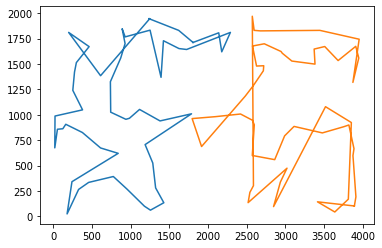

In [932]:
for graph in best_kroa100:
    x = ver_data[graph, 0]
    y = ver_data[graph,1]
    plt.plot(x, y)

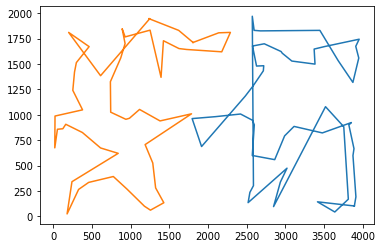

In [933]:
for graph in sol:
    x = ver_data[graph, 0]
    y = ver_data[graph,1]
    plt.plot(x, y)